# Kaggle Challenge: Classifying Emotions of Tweets Using Only SVM and Random Forest

In this project, I created a model to perform sentiment analysis on tweets, working with a large labeled dataset of 400,000+ examples: https://www.kaggle.com/datasets/nelgiriyewithana/emotions.

I used only a combination of **Random Forest classifiers** and **Support Vector Machines (SVMs)** with a linear kernel (no deep learning allowed!) to get 93% testing accuracy.

This project demonstrates that even with an ambiguous task like emotion classification, it's possible to achieve accuracy that rivals deep learning approaches by doing careful data preprocessing and being thoughtful about leveraging and combining the strengths of traditional classifiers.


### `02_model_training_eval.ipynb`: building & tuning the model, validation, testing.

I split the data into training, validation, and test sets. First, I tune and validate a Random Forest classifier and linear SVM classifier separately to assess their individual capabilities on this dataset. Then, I perform dimensionality reduction using the top-ranked features from the Random Forest classifier and build a stacked model combining the strengths of both classifiers.

The final stacked model achieves 94% validation accuracy and 93% on the test set.


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

import time
import re
from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.discriminant_analysis import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Vectorization

Read pre-processed data:


In [ ]:
df = pd.read_csv('data/text_processed.csv', index_col=0)

df = df.dropna(subset=['text'])

X = df['text']
y = df['label']

print(X.head())
print(y.head())

0                           feel helpless heavy heated
1    enjoy able slouch relax unwind frankly need we...
2                 give internship dark feel distraught
3                                       know feel lost
4    kindergarten teacher thoroughly weary job havi...
Name: text, dtype: object
0    4
1    0
2    4
3    0
4    4
Name: label, dtype: int64


Split the data into training, validation, and test sets. A split of 80%-10%-10% is justifiable with 400,000+ data points and provides more training data while leaving plenty of validation/testing points.


In [7]:
X_train, X_20, y_train, y_20 = train_test_split(
    X, y, test_size=0.2, random_state=9
)

X_val, X_test, y_val, y_test = train_test_split(
    X_20, y_20, test_size=0.5, random_state=9
)

print(f"Training set length: {len(X_train)}")
print(f"Validation set length: {len(X_val)}")
print(f"Testing set length: {len(X_test)}")

Training set length: 333429
Validation set length: 41679
Testing set length: 41679


Using a **TF-IDF** vectorizer, since:

- It'll account for the relative frequency of each word
- It'll account for how unique the words in each tweet are across the document, so more meaningful words are emphasized
- I'm not using a deep learning model, so not using sequential data or context here

For now, I have `max_features=5000`, since I reduce dimensionality strategically later.


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))

# only fit vectorizer to training set
X_train_tfidf = vectorizer.fit_transform(X_train)
dump(vectorizer, "models/tfidf_vectorizer.joblib")

X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

## RF Classifier Only

I begin by tuning a Random Forest classifier on the training set. The two most impactful hyperparameters for both accuracy and runtime are the number of trees (`n_estimators`) and the maximum depth of each tree (`max_depth`).

To efficiently explore the parameter space, I use `RandomizedSearchCV` to balance optimization and speed.


In [ ]:
classifier = RandomForestClassifier()

param_distributions = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "max_depth": [10, 20, 30, 50, 100, None]
}

# limit to 20 iterations for random search, and parallelize
random_search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_distributions,
    n_iter=15,
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# fit to training data only to avoid data leakage
# subsets used find best-performing parameters
random_search.fit(X_train_tfidf, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END .....................max_depth=30, n_estimators=250; total time=  45.9s
[CV] END .....................max_depth=30, n_estimators=250; total time=  46.2s
[CV] END .....................max_depth=30, n_estimators=250; total time=  46.6s
[CV] END .....................max_depth=50, n_estimators=150; total time=  53.4s
[CV] END .....................max_depth=50, n_estimators=150; total time=  53.9s
[CV] END .....................max_depth=50, n_estimators=150; total time=  54.3s
[CV] END .....................max_depth=30, n_estimators=200; total time=  34.5s
[CV] END .....................max_depth=30, n_estimators=200; total time=  36.7s
[CV] END .....................max_depth=30, n_estimators=200; total time=  38.1s
[CV] END .....................max_depth=20, n_estimators=250; total time=  21.7s
[CV] END .....................max_depth=10, n_estimators=150; total time=   7.4s
[CV] END .....................max_depth=50, n_es

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...................max_depth=None, n_estimators=100; total time= 6.8min
[CV] END ...................max_depth=None, n_estimators=100; total time= 6.9min
[CV] END ....................max_depth=100, n_estimators=300; total time= 4.6min
[CV] END ....................max_depth=100, n_estimators=300; total time= 4.6min
[CV] END ...................max_depth=None, n_estimators=100; total time= 6.9min
[CV] END ....................max_depth=100, n_estimators=250; total time= 2.7min
[CV] END ....................max_depth=100, n_estimators=250; total time= 3.9min
[CV] END ....................max_depth=100, n_estimators=250; total time= 3.8min
[CV] END ...................max_depth=None, n_estimators=150; total time= 8.7min
[CV] END ...................max_depth=None, n_estimators=150; total time= 8.7min
[CV] END ...................max_depth=None, n_estimators=150; total time= 8.8min
[CV] END ...................max_depth=None, n_estimators=200; total time=11.4min
[CV] END ...................

Best parameters: `{'n_estimators': 100, 'max_depth': None}`

Best score: `0.8546557138101365`

`max_depth=None` gives the highest accuracy, allowing trees to grow fully and capture complex patterns in the data. With 100 trees, the ensemble effect of Random Forest helps reduce the risk of overfitting, even with deep individual trees. This choice can be sanity checked by checking performance on the validation set.

Training the RF classifier with the chosen parameters:


In [5]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=0,
    n_jobs=-1
)

start = time.time()
rf_classifier.fit(X_train_tfidf, y_train)
end = time.time()

print(f"Trained in {end - start} seconds.")

Trained in 70.61570310592651 seconds.


Validating the RF classifier on the validation set:



Random Forest Validation Accuracy: 0.8424626310612059

Random Forest Validation Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     11973
           1       0.88      0.87      0.87     14190
           2       0.68      0.65      0.66      3540
           3       0.85      0.87      0.86      5800
           4       0.77      0.82      0.79      4648
           5       0.63      0.63      0.63      1528

    accuracy                           0.84     41679
   macro avg       0.78      0.79      0.79     41679
weighted avg       0.84      0.84      0.84     41679



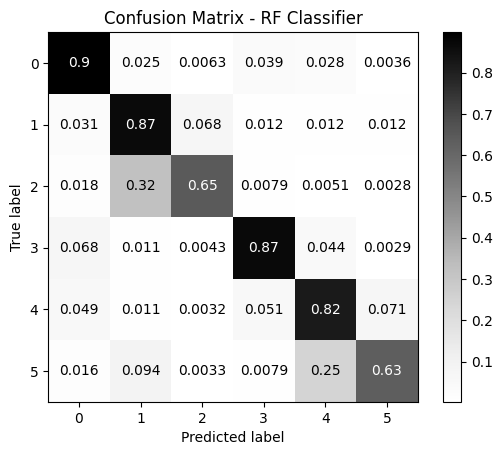

In [7]:
y_pred_rf = rf_classifier.predict(X_val_tfidf)

print("\nRandom Forest Validation Accuracy:", accuracy_score(y_val, y_pred_rf))

print("\nRandom Forest Validation Report:")
print(classification_report(y_val, y_pred_rf))

cm = confusion_matrix(y_val, y_pred_rf)
cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

ConfusionMatrixDisplay(
    confusion_matrix = cm_percentage,
    display_labels = rf_classifier.classes_
).plot(cmap=plt.cm.Greys)
plt.title("Confusion Matrix - RF Classifier")
plt.show()

As expected, there's a lot of struggle classifying Love and Surprise. These emotions are both infrequently represented and similar in tone/vocabulary to other emotions in the dataset.


## Linear SVM Classifier Only

Next, I tune an SVM classifier on the training set. I'm sticking with a linear kernel for creating decision boundaries as it generally tends to perform well on text-based classification tasks.

I use a `LinearSVC` wrapped in a pipeline with `StandardScaler` to normalize input features. Two hyperparameters are tuned:

- `C`: Controls the trafe-off between margin size and classification accuracy. Lower values encourage simpler models, while higher values aim to reduce misclassification.
- `max_iter`: A larger number of training iterations is more effective at ensuring convergence for finding boundaries, but also increases runtime.

Since the number of features is less than the number of training samples, we can set `dual=False`, allowing SVM to solve the primal optimization problem directly and increase computational efficiency.

For tuning, I perform a grid search over a range of different parameter values, optimizing for **weighted F1 score to account for class imbalance.**


In [11]:
pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(random_state=0, dual=False)
)

param_grid = {
    'linearsvc__C': [0.01, 0.1, 1, 10, 100],
    'linearsvc__max_iter': [1000, 3000, 5000, 10000, 15000]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_tfidf, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=1000; total time=  19.4s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=3000; total time=  19.4s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=3000; total time=  20.7s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=1000; total time=  21.0s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=3000; total time=  21.1s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=5000; total time=  21.1s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=1000; total time=  21.6s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=5000; total time=  21.6s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=3000; total time=  23.4s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=1000; total time=  23.5s
[CV] END ........linearsvc__C=0.01, linearsvc__max_iter=3000; total time=  25.0s
[CV] END ........linearsvc__C=0.01, linearsvc__

Best parameters: `{'linearsvc__C': 0.01, 'linearsvc__max_iter': 1000}`

Best score: `0.8864029799243494`

Defining an SVM classifier with the above parameters and training:


In [13]:
svm_classifier = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(verbose=2, max_iter=1000, C=0.01, dual=False, random_state=0)
)

start = time.time()
svm_classifier.fit(X_train_tfidf, y_train)
end = time.time()

print(f"Trained in {end - start} seconds.")

[LibLinear]iter  1 act 2.644e+03 pre 2.551e+03 delta 7.667e-01 f 3.334e+03 |g| 1.012e+04 CG   3
iter  2 act 1.825e+02 pre 1.498e+02 delta 7.667e-01 f 6.901e+02 |g| 9.661e+02 CG   7
iter  3 act 6.117e+01 pre 4.895e+01 delta 7.667e-01 f 5.076e+02 |g| 4.230e+02 CG   8
iter  4 act 2.042e+01 pre 1.700e+01 delta 7.667e-01 f 4.464e+02 |g| 1.986e+02 CG   9
iter  5 act 4.444e+00 pre 3.934e+00 delta 7.667e-01 f 4.260e+02 |g| 8.427e+01 CG  16
iter  6 act 3.434e-01 pre 3.236e-01 delta 7.667e-01 f 4.215e+02 |g| 2.430e+01 CG  19
iter  7 act 1.720e-02 pre 1.541e-02 delta 7.667e-01 f 4.212e+02 |g| 3.446e+00 CG  25
iter  8 act 3.083e-03 pre 2.688e-03 delta 7.667e-01 f 4.212e+02 |g| 7.104e-01 CG  31
iter  1 act 2.538e+03 pre 2.440e+03 delta 7.663e-01 f 3.334e+03 |g| 8.811e+03 CG   3
iter  2 act 1.903e+02 pre 1.545e+02 delta 7.663e-01 f 7.958e+02 |g| 9.927e+02 CG   6
iter  3 act 6.639e+01 pre 5.292e+01 delta 7.663e-01 f 6.055e+02 |g| 4.424e+02 CG   8
iter  4 act 2.353e+01 pre 1.951e+01 delta 7.663e-01 f 

Validating the SVM classifier:


SVM Validation Accuracy: 0.8860577269128338

SVM Validation Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     11973
           1       0.91      0.92      0.91     14190
           2       0.78      0.74      0.76      3540
           3       0.90      0.88      0.89      5800
           4       0.84      0.85      0.84      4648
           5       0.73      0.72      0.72      1528

    accuracy                           0.89     41679
   macro avg       0.85      0.84      0.84     41679
weighted avg       0.89      0.89      0.89     41679



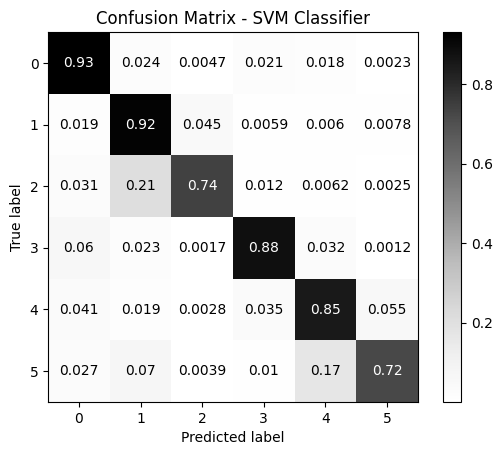

In [15]:
y_pred_svm = svm_classifier.predict(X_val_tfidf)

print("SVM Validation Accuracy:", accuracy_score(y_val, y_pred_svm))

print("\nSVM Validation Report:")
print(classification_report(y_val, y_pred_svm))

cm = confusion_matrix(y_val, y_pred_svm)
cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage, display_labels=svm_classifier.classes_
    ).plot(cmap=plt.cm.Greys)

plt.title("Confusion Matrix - SVM Classifier")
plt.show()

SVM achieves slightly higher validation accuracy than the Random Forest classifier, with a similar-looking confusion matrix.

Both SVM and RF struggled slightly with this task, especially when dealing with the class imbalances. Because the emotions dataset is very diverse, I wouldn't have expected SVM to be able to draw highly accurate boundaries, or RF to perfectly capture all of the relationships between text and emotions.


## Dimensionality reduction using Random Forest feature importance

Next, I want to experiment with a stacked classifier, but this means I'll need to be mindful of runtime. Because of this, I'll perform a dimensionality reduction by selecting a subset of features based on their **importance scores from the trained RF model**.

By prioritizing features based on RF importance, my goal is to preserve the RF classifier's ability to detect subtle patterns in the data and preserve its validation accuracy as much as possible, while also reducing redundancy and noise so that the SVM classifier can draw cleaner boundaries.


In the process below, I experiment with a range of **100 to 5,000 top-ranked features**, and evaluate each feature set using only the **SVM classifier**. Since the reduced features are ranked by what the RF model deems most informative, I assume RF performance will be largely preserved. Therefore, I use SVM validation accuracy to select the optimal number of features, choosing the point where SVM performance is highest.

This strategy ensures that the final stacked classifier will benefit as much as possible from both models within an efficient feature space.


100 features: trained in 1.8152687549591064 seconds.
Validation accuracy: 0.6135703831665827

400 features: trained in 2.832827091217041 seconds.
Validation accuracy: 0.8750689795820437

700 features: trained in 3.540076971054077 seconds.
Validation accuracy: 0.894551212840999

1000 features: trained in 4.150909185409546 seconds.
Validation accuracy: 0.8965666162815806

1300 features: trained in 4.755993127822876 seconds.
Validation accuracy: 0.8947431560258163

1600 features: trained in 4.7447850704193115 seconds.
Validation accuracy: 0.8940473619808537

1900 features: trained in 4.683628082275391 seconds.
Validation accuracy: 0.8928957028719499

2200 features: trained in 4.907724618911743 seconds.
Validation accuracy: 0.8927037596871326

2500 features: trained in 5.197806119918823 seconds.
Validation accuracy: 0.8917920295592504

2800 features: trained in 5.531098127365112 seconds.
Validation accuracy: 0.8909042923294704

3100 features: trained in 5.852275848388672 seconds.
Validatio

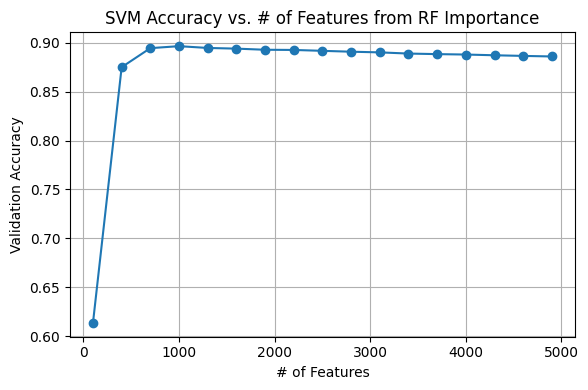

In [37]:
rf_importances = rf_classifier.feature_importances_
sorted_indices = np.argsort(rf_importances)[::-1]

feature_counts = list(range(100, 5001, 300))

accuracies = []

for N in feature_counts:
    indices = sorted_indices[:N]

    svm_classifier_reduced = make_pipeline(
        StandardScaler(with_mean=False),
        LinearSVC(verbose=0, max_iter=1000, C=0.01, dual=False, random_state=0)
    )

    start = time.time()
    svm_classifier_reduced.fit(X_train_tfidf[:, indices], y_train)
    end = time.time()

    print(f"{N} features: trained in {end - start} seconds.")

    y_pred = svm_classifier_reduced.predict(X_val_tfidf[:, indices])
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

    print(f"Validation accuracy: {accuracy}\n")

plt.figure(figsize=(6, 4))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("SVM Accuracy vs. # of Features from RF Importance")
plt.xlabel("# of Features")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

It looks like SVM performs best with around **1,000 features**. At this point, the model has enough high-quality, informative features to form strong decision boundaries. As the feature space dimensionality increases, performance begins to slightly decline, indicating that noisy or redundant features have been introduced.


Accuracy report and confusion matrix for 1,000 features:


In [60]:
N = 1000
indices = sorted_indices[:N]
np.save("models/top_indices.npy", indices)

In [ ]:
svm_classifier_reduced = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(verbose=2, max_iter=1000, C=0.01, dual=False, random_state=0)
)

start = time.time()
svm_classifier_reduced.fit(X_train_tfidf[:, indices], y_train)
end = time.time()
print(f"Trained in {end - start} seconds.")

[LibLinear]iter  1 act 2.632e+03 pre 2.526e+03 delta 7.924e-01 f 3.334e+03 |g| 9.311e+03 CG   3
iter  2 act 1.812e+02 pre 1.479e+02 delta 7.924e-01 f 7.018e+02 |g| 9.300e+02 CG   5
iter  3 act 5.590e+01 pre 4.484e+01 delta 7.924e-01 f 5.206e+02 |g| 3.772e+02 CG   5
iter  4 act 1.723e+01 pre 1.438e+01 delta 7.924e-01 f 4.647e+02 |g| 1.547e+02 CG   7
iter  5 act 2.990e+00 pre 2.659e+00 delta 7.924e-01 f 4.475e+02 |g| 6.064e+01 CG  10
iter  6 act 2.670e-01 pre 2.459e-01 delta 7.924e-01 f 4.445e+02 |g| 1.449e+01 CG  16
iter  7 act 1.631e-02 pre 1.459e-02 delta 7.924e-01 f 4.442e+02 |g| 1.902e+00 CG  25
iter  8 act 2.533e-03 pre 2.490e-03 delta 7.924e-01 f 4.442e+02 |g| 4.015e-01 CG  42
iter  1 act 2.531e+03 pre 2.423e+03 delta 7.871e-01 f 3.334e+03 |g| 8.412e+03 CG   3
iter  2 act 1.829e+02 pre 1.477e+02 delta 7.871e-01 f 8.028e+02 |g| 9.349e+02 CG   5
iter  3 act 5.956e+01 pre 4.741e+01 delta 7.871e-01 f 6.199e+02 |g| 3.869e+02 CG   6
iter  4 act 1.973e+01 pre 1.634e+01 delta 7.871e-01 f 

SVM Validation Accuracy (reduced to 1000 features): 0.8965666162815806

SVM Validation Report (reduced to 1000 features):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     11973
           1       0.91      0.93      0.92     14190
           2       0.82      0.75      0.78      3540
           3       0.91      0.89      0.90      5800
           4       0.86      0.87      0.87      4648
           5       0.79      0.74      0.76      1528

    accuracy                           0.90     41679
   macro avg       0.87      0.85      0.86     41679
weighted avg       0.90      0.90      0.90     41679



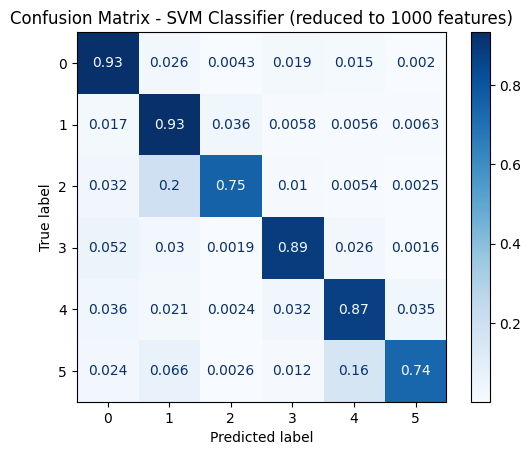

In [42]:
dump(svm_classifier_reduced, "models/svm_classifier_reduced.joblib")

y_pred_svm_reduced = svm_classifier_reduced.predict(X_val_tfidf[:, indices])

print(
    f"SVM Validation Accuracy (reduced to {N} features):",
    accuracy_score(y_val, y_pred_svm_reduced)
)

print(f"\nSVM Validation Report (reduced to {N} features):")
print(classification_report(y_val, y_pred_svm_reduced))

cm = confusion_matrix(y_val, y_pred_svm_reduced)
cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage, display_labels=svm_classifier_reduced.classes_
).plot(cmap=plt.cm.Blues)

plt.title(f"Confusion Matrix - SVM Classifier (reduced to {N} features)")
plt.show()

## Final Model - Stacking RF and SVM

For the final model, I construct a **stacked classifier** that takes advantage of combining the complementary strengths of **Random Forest (RF)** and **Linear SVM**.

RF is highly effective at capturing subtle, nonlinear patterns in the data, which is a great advantage when dealing with an ambiguous task like sentiment analysis. On the other hand, SVM is effective at drawing high-margin decision boundaries for a robust, generalizable model.

I've just performed a feature reduction based on RF importance, with the goal of preserving RF's ability to detect complex patterns as much as possible, while also optimizing accuracy for the SVM.

The stacking setup is structued as follows:

- **RF is trained separately** on the training set.
- **SVM is trained separately** on the training set.
- Their **class probability predictions**, which represent how confident each model is that a data point belongs to each class, are used as input features to train a **meta-classifier.**

The purpose of the meta-classifier is to learn the patterns for when and how each base classifier (RM or SVM) is more reliable given different types of input, so it can make a more informed final prediction.

In terms of deciding on a meta-classifier, I decided to go with _another_ **Random Forest** classifier.

- For this sentiment analysis problem, determining the inputs for which SVM outperforms RF and vice versa is likely not a clear-cut problem.
- By using RF as the final estimator, the model can once again uncover complex patterns in the interaction between base model outputs.
- Ultimately, by letting each model contribute where it's strongest, and using RF to capture the suble interaction between their predictions, the final model is well-suited to handle ambiguity.

The entire stacking procedure uses 5-fold cross-validation, ensuring that the meta-classifier learns from out-of-fold predictions, keeping it robust and unbiased.


In [43]:
svm_classifier_stacking = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(verbose=1, max_iter=1000, C=0.01, dual=False, random_state=0)
)

rf_classifier_stacking = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=0,
    n_jobs=-1
)

base_learners = [
    ("rf", rf_classifier_stacking),
    ("svm", svm_classifier_stacking)
]

# k-fold cross validation, k = 5
stacked_classifier = StackingClassifier(
    estimators=base_learners,
    final_estimator=rf_classifier_stacking,
    cv=5,
    n_jobs=-1,
    verbose=2
)

start = time.time()
# train stacking classifier on reduced features
stacked_classifier.fit(X_train_tfidf[:, indices], y_train)
end = time.time()

print(f"Trained in {end - start} seconds.")
dump(stacked_classifier, "models/stacked_classifier.joblib")

[LibLinear]iter  1 act 2.632e+03 pre 2.526e+03 delta 7.924e-01 f 3.334e+03 |g| 9.311e+03 CG   3
iter  2 act 1.812e+02 pre 1.479e+02 delta 7.924e-01 f 7.018e+02 |g| 9.300e+02 CG   5
iter  3 act 5.590e+01 pre 4.484e+01 delta 7.924e-01 f 5.206e+02 |g| 3.772e+02 CG   5
iter  4 act 1.723e+01 pre 1.438e+01 delta 7.924e-01 f 4.647e+02 |g| 1.547e+02 CG   7
iter  5 act 2.990e+00 pre 2.659e+00 delta 7.924e-01 f 4.475e+02 |g| 6.064e+01 CG  10
iter  6 act 2.670e-01 pre 2.459e-01 delta 7.924e-01 f 4.445e+02 |g| 1.449e+01 CG  16
iter  7 act 1.631e-02 pre 1.459e-02 delta 7.924e-01 f 4.442e+02 |g| 1.902e+00 CG  25
iter  8 act 2.533e-03 pre 2.490e-03 delta 7.924e-01 f 4.442e+02 |g| 4.015e-01 CG  42
iter  1 act 2.531e+03 pre 2.423e+03 delta 7.871e-01 f 3.334e+03 |g| 8.412e+03 CG   3
iter  2 act 1.829e+02 pre 1.477e+02 delta 7.871e-01 f 8.028e+02 |g| 9.349e+02 CG   5
iter  3 act 5.956e+01 pre 4.741e+01 delta 7.871e-01 f 6.199e+02 |g| 3.869e+02 CG   6
iter  4 act 1.973e+01 pre 1.634e+01 delta 7.871e-01 f 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]iter  1 act 2.107e+03 pre 2.022e+03 delta 7.926e-01 f 2.667e+03 |g| 7.456e+03 CG   3
iter  1 act 2.107e+03 pre 2.022e+03 delta 7.924e-01 f 2.667e+03 |g| 7.443e+03 CG   3
iter  1 act 2.106e+03 pre 2.020e+03 delta 7.925e-01 f 2.667e+03 |g| 7.451e+03 CG   3
iter  1 act 2.106e+03 pre 2.020e+03 delta 7.922e-01 f 2.667e+03 |g| 7.447e+03 CG   3
iter  1 act 2.106e+03 pre 2.021e+03 delta 7.924e-01 f 2.667e+03 |g| 7.452e+03 CG   3
iter  2 act 1.450e+02 pre 1.182e+02 delta 7.926e-01 f 5.604e+02 |g| 7.452e+02 CG   5
iter  2 act 1.449e+02 pre 1.184e+02 delta 7.924e-01 f 5.601e+02 |g| 7.442e+02 CG   5
iter  2 act 1.449e+02 pre 1.183e+02 delta 7.924e-01 f 5.613e+02 |g| 7.437e+02 CG   5
iter  2 act 1.452e+02 pre 1.182e+02 delta 7.925e-01 f 5.619e+02 |g| 7.447e+02 CG   5
iter  2 act 1.457e+02 pre 1.189e+02 delta 7.922e-01 f 5.619e+02 |g| 7.445e+02 CG   5
iter  3 act 4.476e+01 pre 3.591e+01 delta 7.926e-01 f 4.155e+02 |g| 3.012e+02 CG   5
iter  3 ac

[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.7s remaining:    6.5s


iter  8 act 3.036e-02 pre 3.089e-02 delta 5.026e-01 f 1.046e+02 |g| 2.776e+00 CG  34
iter  9 act 1.799e-03 pre 1.772e-03 delta 5.026e-01 f 1.045e+02 |g| 5.351e-01 CG  40
iter 10 act -9.487e-05 pre 4.436e-05 delta 8.522e-04 f 1.045e+02 |g| 7.806e-02 CG  53
cg reaches trust region boundary
iter 10 act 2.748e-05 pre 2.741e-05 delta 8.561e-04 f 1.045e+02 |g| 7.806e-02 CG   8


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.9min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Trained in 389.3362922668457 seconds.


['models/stacked_classifier.joblib']

The stacked model trained in about 6.5 minutes.
Validating the stacked model on the validation set (keeping reduced feature space):


Stacked Classifier Validation Accuracy: 0.934595359773507

Stacked Classifier Validation Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     11973
           1       0.95      0.95      0.95     14190
           2       0.91      0.88      0.89      3540
           3       0.93      0.93      0.93      5800
           4       0.91      0.92      0.92      4648
           5       0.91      0.90      0.90      1528

    accuracy                           0.93     41679
   macro avg       0.92      0.92      0.92     41679
weighted avg       0.93      0.93      0.93     41679



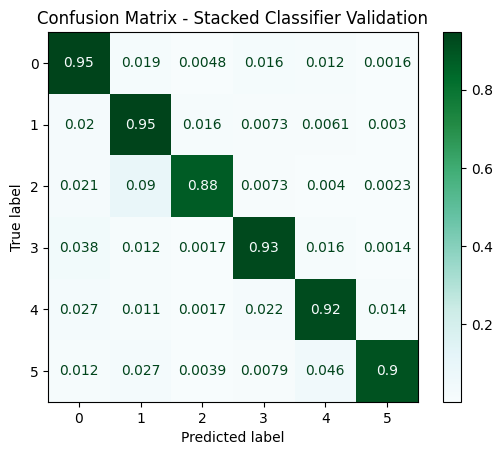

In [58]:
y_pred_stack = stacked_classifier.predict(X_val_tfidf[:, indices])

print("Stacked Classifier Validation Accuracy:", accuracy_score(y_val, y_pred_stack))

print("\nStacked Classifier Validation Report:")
print(classification_report(y_val, y_pred_stack))

cm = confusion_matrix(y_val, y_pred_stack)
cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage, display_labels=stacked_classifier.classes_
).plot(cmap=plt.cm.BuGn)

plt.title("Confusion Matrix - Stacked Classifier Validation")
plt.show()

The stacked model achieved 94% validation accuracy! The confusion matrix is also significantly cleaner. Love and Surprise are still slightly difficult to classify, but now to a much more acceptable degree.


### Predicted class probabilities vs. actual class distribution

To sanity check how well-calibrated the stacked classifier is, I'll quickly calculate the average predicted probabilities across the validation set for each emotion class, then compare these values to the true class distribution in the validation labels.


In [48]:
probabilities = stacked_classifier.predict_proba(X_val_tfidf[:, indices])
avg_probabilities = np.mean(probabilities, axis=0)

print("Average probabilities for each class:")
print(avg_probabilities)

class_frequencies = y_val.value_counts(normalize=True)
class_frequencies = class_frequencies.sort_index()

print("\nClass frequencies:")
print(class_frequencies.values)

Average probabilities for each class:
[0.28721295 0.3403931  0.08393327 0.13858561 0.11285079 0.03702428]

Class frequencies:
[0.28726697 0.34045922 0.08493486 0.13915881 0.11151899 0.03666115]


The predicted probabilities align very closely with the actual class frequencies, indicating that the model is calibrated and balanced.

Combined with the results in the classification report and confusion matrix, this is a sign that the model is robust, generalizable, and has done a good job dealing with class imbalance.


## Model Testing

All tuning and validation was done using the validation set only.

Finally, test the stacked classifier on the **test set**, which has been unused until now.


Stacked Classifier Testing Accuracy: 0.9336116509513184

Stacked Classifier Testing Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12211
           1       0.95      0.95      0.95     14121
           2       0.90      0.88      0.89      3470
           3       0.92      0.93      0.93      5710
           4       0.91      0.92      0.92      4708
           5       0.91      0.89      0.90      1459

    accuracy                           0.93     41679
   macro avg       0.92      0.92      0.92     41679
weighted avg       0.93      0.93      0.93     41679



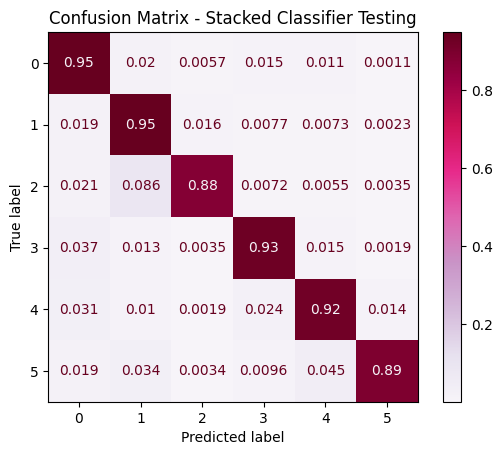

In [52]:
y_pred_stack_test = stacked_classifier.predict(X_test_tfidf[:, indices])

print("Stacked Classifier Testing Accuracy:", accuracy_score(y_test, y_pred_stack_test))

print("\nStacked Classifier Testing Classification Report:")
print(classification_report(y_test, y_pred_stack_test))

cm = confusion_matrix(y_test, y_pred_stack_test)
cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage, display_labels=stacked_classifier.classes_
).plot(cmap=plt.cm.PuRd)

plt.title("Confusion Matrix - Stacked Classifier Testing")
plt.show()

### **Test accuracy**: 93.36%

- Highest f1-scores in joy (0.95) and sadness (0.94), likely due to clearer linguistic patterns and greater representation
- Slightly lower f1 for love (0.89) and surprise (0.90), reflecting that these emotions are more ambiguous and less represented
- Precision, recall and f1-scores are consistently high across all 6 classes, indicating no major class bias
- Training time: ~6.5 minutes on a Mac M2

Overall, this approach using a combination of RF and SVM classifiers achieved high performance on an ambiguous task with low compute, which is a nod to the power of classical machine learning!
